In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import metrics
from keras.optimizers import Adam
from keras.metrics import Precision
from tqdm.keras import TqdmCallback
from keras.callbacks import EarlyStopping
from keras.metrics import AUC, Precision, Recall

In [106]:
base = pd.read_excel('/content/Base de Dados PEDE.xlsx')

In [107]:
base.head()

,ano_pede,ra,fase,turma,nome,data_nasc,idade,genero,ano_ingresso,instituicao_ensino,...,atingiu_pv,ipv,ian,fase_ideal,defasagem,destaque_ieg,destaque_ida,destaque_ivp,escola,ativo_inativo
0,2024,RA-1275,ALFA,ALFA A - G0/G1,Aluno-1275,2016-07-28 00:00:00,8,Masculino,2024,Pública,...,NaN,5.446667,10.0,ALFA (1° e 2° ano),0,NaN,NaN,NaN,EE Chácara Florida II,Cursando
1,2024,RA-1276,ALFA,ALFA A - G0/G1,Aluno-1276,2016-10-16 00:00:00,8,Feminino,2024,Pública,...,NaN,7.050000,10.0,ALFA (1° e 2° ano),0,NaN,NaN,NaN,EE Chácara Florida II,Cursando
2,2024,RA-1277,ALFA,ALFA A - G0/G1,Aluno-1277,2016-08-16 00:00:00,8,Masculino,2024,Pública,...,NaN,7.046667,10.0,ALFA (1° e 2° ano),0,NaN,NaN,NaN,EE Dom Pedro Villas Boas de Souza,Cursando
3,2024,RA-868,ALFA,ALFA A - G0/G1,Aluno-868,2015-11-08 00:00:00,8,Masculino,2023,Pública,...,NaN,7.213333,5.0,Fase 1 (3° e 4° ano),-1,NaN,NaN,NaN,EE Chácara Florida II,Cursando
4,2024,RA-1278,ALFA,ALFA A - G0/G1,Aluno-1278,2015-03-22 00:00:00,9,Masculino,2024,Pública,...,NaN,4.173333,5.0,Fase 1 (3° e 4° ano),-1,NaN,NaN,NaN,EM Etelvina Delfim Simões,Cursando


In [108]:
base.shape

(3030, 54)

In [109]:
################################# FUNÇÕES PARA REGULARIZAR COLUNAS ##############################################

# Transformar coluna em número, se encontrar algo que não seja número em vez de dar erro transforma em NaN
def coerce_numeric(series):
    return pd.to_numeric(series, errors="coerce")


def extrair_fase(valor):
    if pd.isna(valor):
        return None

    valor = str(valor).lower()

    if "alfa" in valor:
        return 0

    match = re.search(r"fase\s*(\d+)", valor)
    if match:
        return int(match.group(1))

    return None



In [110]:
base["inde_2024"] = base["inde_2024"].replace("INCLUIR", np.nan)
base["inde_2024"] = coerce_numeric(base["inde_2024"])
base["fase_ideal"] = base["fase_ideal"].apply(extrair_fase)

/tmp/ipython-input-3211482316.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base["inde_2024"] = base["inde_2024"].replace("INCLUIR", np.nan)


In [111]:
######################## REMOVENDO COLUNAS QUE NÃO AGREGAM ##########################################

colunas_para_remover = ["ra",
                        "fase",
                        "turma",
                        "nome",
                        "data_nasc",
                        "idade",
                        "genero",
                        "ano_ingresso",
                        "instituicao_ensino",
                        "pedra_2020",
                        "pedra_2021",
                        "pedra_2022",
                        "pedra_2023",
                        "pedra_2024",
                        "cg",
                        "cf",
                        "ct",
                        "avaliador_1",
                        "rec_av1",
                        "avaliador_2",
                        "rec_av2",
                        "avaliador_3",
                        "rec_av3",
                        "avaliador_4",
                        "rec_av4",
                        "avaliador_5",
                        "rec_av5",
                        "avaliador_6",
                        "rec_av6",
                        "rec_psicologia",
                        "indicado",
                        "atingiu_pv",
                        "destaque_ieg",
                        "destaque_ida",
                        "destaque_ivp",
                        "escola",
                        "ativo_inativo",
                        "inde_2024"
]

base = base.drop(columns=colunas_para_remover, errors="ignore")

In [112]:
base.head()

,ano_pede,inde_2022,inde_2023,n_av,iaa,ieg,ips,ipp,ida,mat,por,ing,ipv,ian,fase_ideal,defasagem
0,2024,NaN,NaN,3.0,10.002,8.666667,6.26,5.625,8.0,10.0,6.0,NaN,5.446667,10.0,0,0
1,2024,NaN,NaN,3.0,10.002,9.333333,3.76,7.500,8.0,10.0,6.0,NaN,7.050000,10.0,0,0
2,2024,NaN,NaN,3.0,10.002,9.083333,3.76,7.500,8.0,10.0,6.0,NaN,7.046667,10.0,0,0
3,2024,NaN,8.63895,3.0,8.002,9.750000,3.76,6.875,7.0,8.0,6.0,NaN,7.213333,5.0,1,-1
4,2024,NaN,NaN,3.0,9.002,4.166667,3.76,5.000,7.5,8.0,7.0,NaN,4.173333,5.0,1,-1


In [113]:
######################################### CRIAÇÃO DA TARGET #########################################

# Definição do target: Risco de defasagem no próximo ano
# IAN:  Indicador de Adequaça o ao Ní vel – Me dia das Notas de Adequaça o do Aluno ao ní vel atual
# Risco = 1 se IAN <= 5 (moderado ou severo)
# Risco = 0 se IAN == 10 (adequado).

base['risco_defasagem_atual'] = (base['ian'] <= 5).astype(int)

In [114]:
base["risco_defasagem_atual"].value_counts()

,count
risco_defasagem_atual,
1,1687
0,1343


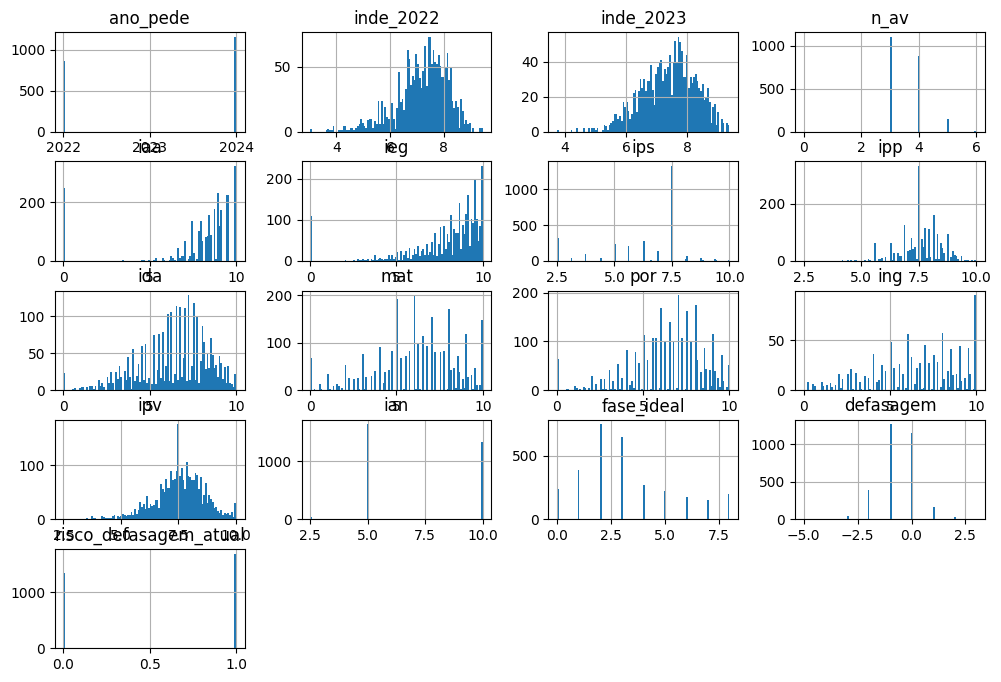

In [115]:
base.hist(bins=100, figsize=(12,8))
plt.show()

<Axes: >

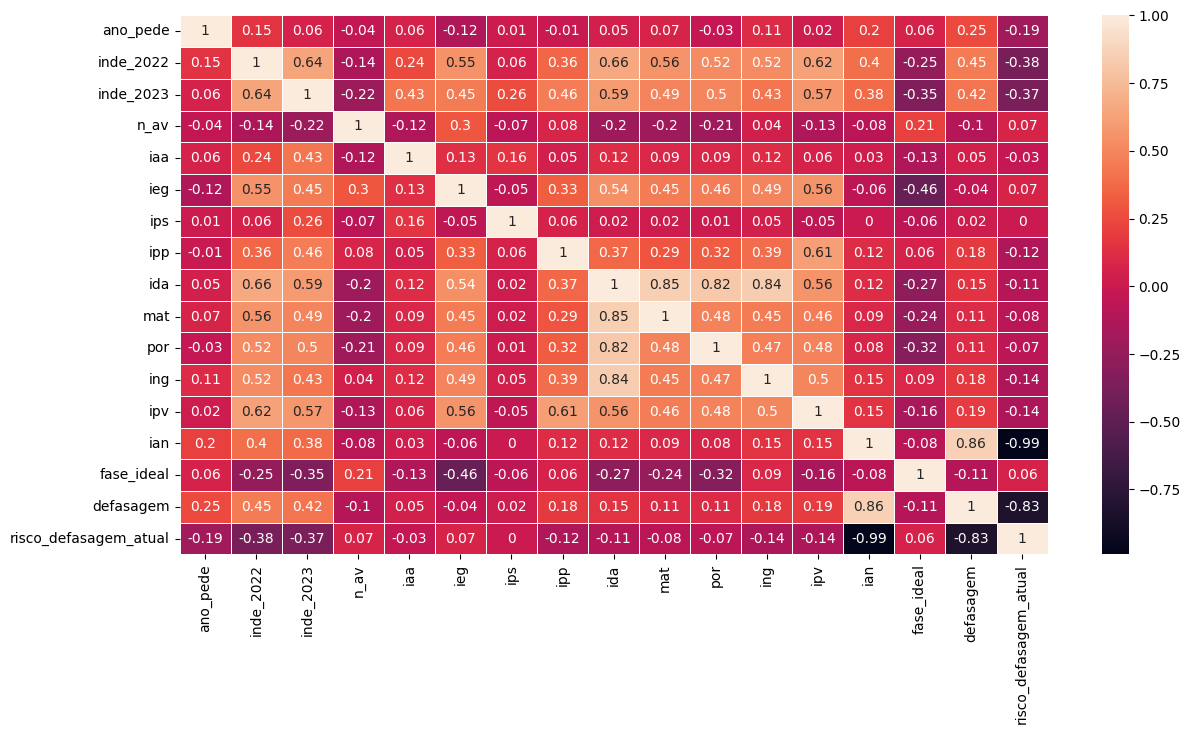

In [116]:
correlation_matrix = base.corr().round(2)

fig, ax = plt.subplots(figsize=(14,7))
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax)


In [118]:
features = [
    "ida",        # Indicador de Aprendizagem - Me dia das Notas do Indicador de Aprendizagem
    "ieg",        # Indicador de Engajamento – Me dia das Notas de Engajamento do Aluno
    "iaa",        # Indicador de Auto Avaliça o – Me dia das Notas de Auto Avaliaça o do Aluno
    "ips",        #Indicador Psicossocial – Me dia das Notas Psicossociais do Aluno
    "ipp",        # Indicador Psicopedago gico – Me dia das Notas Psico Pedago gicas do Aluno
    "ipv",        # Indicador de Ponto de Virada – Me dia das Notas de Ponto de Virada do Aluno
    "n_av",       # Avaliação
    "mat",        # Matemática
    "por",        # Português
    "ing",        # Inglês
    "inde_2022",  # Indice do Desenvolvimento Educacional – Me trica de Processo Avaliativo Geral do Aluno; Dado pela Ponderaça o dos indicadores
    "inde_2023",  # Indice do Desenvolvimento Educacional – Me trica de Processo Avaliativo Geral do Aluno; Dado pela Ponderaça o dos indicadores
    "ano_pede"
]

In [119]:
X = base[features].copy()
y = base["risco_defasagem_atual"].copy()

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Pré Processamento

In [121]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=features,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=features,
    index=X_test.index
)


imputer = KNNImputer(n_neighbors=5, weights="distance")

X_train_imp = pd.DataFrame(
    imputer.fit_transform(X_train_scaled),
    columns=features,
    index=X_train.index
)

X_test_imp = pd.DataFrame(
    imputer.transform(X_test_scaled),
    columns=features,
    index=X_test.index
)

X_train_nn = X_train_imp.to_numpy(dtype="float32")
X_test_nn  = X_test_imp.to_numpy(dtype="float32")

y_train_nn = y_train.to_numpy(dtype="float32").reshape(-1, 1)
y_test_nn  = y_test.to_numpy(dtype="float32").reshape(-1, 1)

Moldando nossas variáveis resposta

Construindo a arquitetura da rede neural multicamadas

In [122]:
tf.random.set_seed(7)

input_shape = X_train_nn.shape[1]

model = models.Sequential([
    layers.Input(shape=(input_shape,)),
    layers.Dense(16, activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        AUC(name="auc"),
        Precision(name="precision"),
        Recall(name="recall")
    ]
)

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 16)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369 (1.44 KB)

 Trainable params: 369 (1.44 KB)

 Non-trainable params: 0 (0.00 B)

In [123]:


epoch = 100

early = EarlyStopping(
    monitor="val_auc",
    mode="max",
    patience=10,
    restore_best_weights=True
)

hist = model.fit(X_train_nn, y_train_nn,
                 validation_data=(X_test_nn, y_test_nn),
                 epochs=100,
                 batch_size=20,
                 shuffle=True,
                 callbacks=[early, TqdmCallback(verbose=0)],
                 verbose=0
)

0epoch [00:00, ?epoch/s]

In [124]:
print("Epocas rodadas:", len(hist.history["loss"]))
print("Melhor val_auc:", max(hist.history["val_auc"]))

Epocas rodadas: 100
Melhor val_auc: 0.9318113327026367


In [125]:
acc = '{:.2%}'.format(hist.history['accuracy'][-1])
print(f"O modelo possui uma acurácia de {acc} com {epoch} epochs de processamento")


O modelo possui uma acurácia de 90.80% com 100 epochs de processamento


Text(0.5, 1.0, 'Erro de treinamento vs validação')

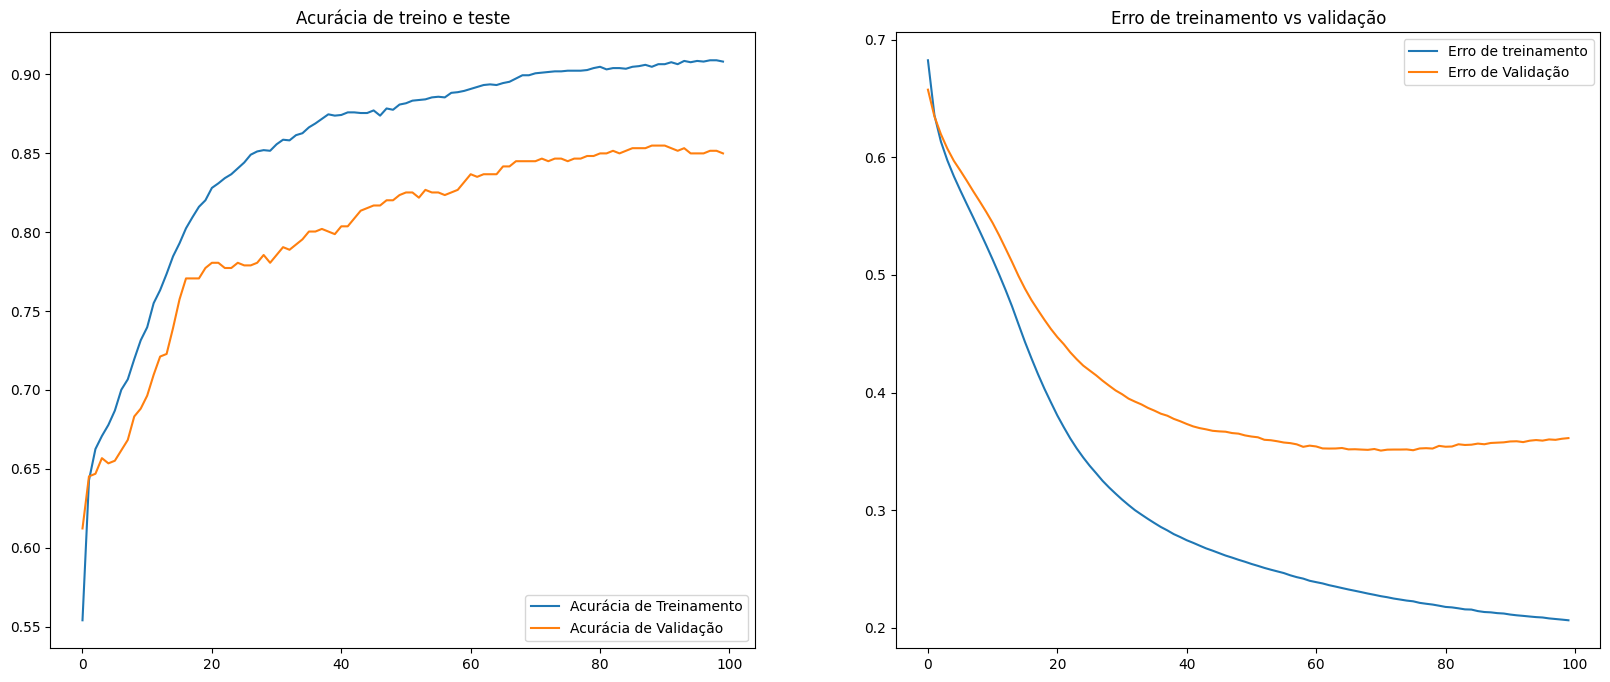

In [126]:
# Visualizando os resultados de treino
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(epoch)

# Plot Acurácia
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treinamento')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de treino e teste')

# Plot Erro de treinamento
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Erro de treinamento')
plt.plot(epochs_range, val_loss, label='Erro de Validação')
plt.legend(loc='upper right')
plt.title('Erro de treinamento vs validação')


NaN em y_pred: 0


In [131]:
from sklearn.metrics import classification_report, confusion_matrix

# probabilidade (0 a 1)
y_pred = model.predict(X_test_nn, verbose=0).ravel()

# classe usando threshold (linha de corte)
threshold = 0.5
y_pred_class = (y_pred >= threshold).astype(int)

print(confusion_matrix(y_test, y_pred_class))
print(classification_report(y_test, y_pred_class, digits=3))


[[221  48]
 [ 40 297]]
              precision    recall  f1-score   support

           0      0.847     0.822     0.834       269
           1      0.861     0.881     0.871       337

    accuracy                          0.855       606
   macro avg      0.854     0.851     0.852       606
weighted avg      0.855     0.855     0.855       606



In [133]:
from sklearn.metrics import roc_auc_score

print("AUC:", roc_auc_score(y_test, y_pred))

AUC: 0.9329807066506348
